In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import os

In [2]:
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 创建输出文件夹
output_folder = "./kmeans_output"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
# 加载数据集
# 使用Kaggle上的Mall Customer Segmentation数据集
try:
    # 尝试从本地加载Kaggle数据集
    data = pd.read_csv("./Mall_Customers.csv")
    print("成功加载本地Mall Customer Segmentation数据集")
except:
    # 如果本地没有，从网络下载
    print("本地未找到数据集，正在尝试下载...")
    try:
        import urllib.request
        url = "https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv"
        urllib.request.urlretrieve(url, "./Mall_Customers.csv")
        data = pd.read_csv("./Mall_Customers.csv")
        print("成功下载并加载Mall Customer Segmentation数据集")
    except:
        # 如果下载失败，创建一个示例数据集
        print("下载失败，创建示例数据集...")
        np.random.seed(42)
        n_samples = 200
        
        # 创建示例数据：年龄、年收入和消费评分
        age = np.random.randint(18, 70, n_samples)
        annual_income = np.random.randint(15, 100, n_samples)
        spending_score = np.random.randint(1, 100, n_samples)
        
        # 创建性别特征
        gender = np.random.choice(['Male', 'Female'], n_samples)
        
        # 创建客户ID
        customer_id = [f'C{i+1}' for i in range(n_samples)]
        
        # 创建DataFrame
        data = pd.DataFrame({
            'CustomerID': customer_id,
            'Gender': gender,
            'Age': age,
            'Annual Income (k$)': annual_income,
            'Spending Score (1-100)': spending_score
        })
        print("已创建示例Mall Customer Segmentation数据集")

# 查看数据集基本信息
print("\n数据集基本信息:")
print(f"数据集形状: {data.shape}")
print("\n数据集前5行:")
print(data.head())

成功加载本地Mall Customer Segmentation数据集

数据集基本信息:
数据集形状: (200, 5)

数据集前5行:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [25]:
# 数据预处理
# 提取需要用于聚类的特征
# 对于Mall Customer数据集，我们使用'Annual Income (k$)'和'Spending Score (1-100)'
X = data[['Annual Income (k$)', 'Spending Score (1-100)']]

# 标准化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

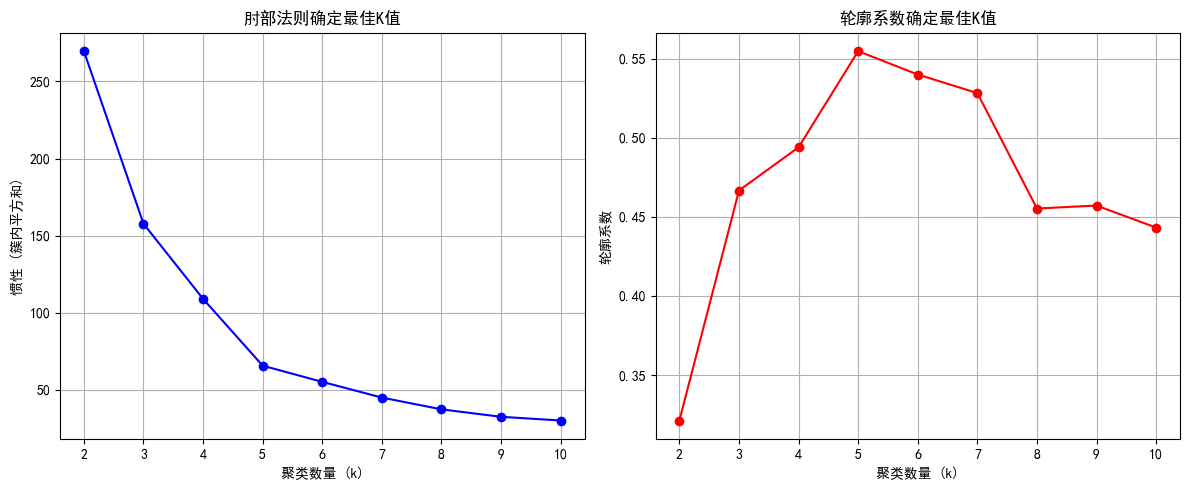


最佳聚类数量 (k): 5


In [31]:
# 确定最佳K值
def find_optimal_k(X, max_k=10):
    """使用肘部法则和轮廓系数确定最佳K值"""
    inertia = []  # 存储每个K值对应的惯性（簇内平方和）
    silhouette_scores = []  # 存储每个K值对应的轮廓系数
    
    k_range = range(2, max_k + 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
        
        # 计算轮廓系数（仅当k>=2时）
        if k >= 2:
            labels = kmeans.labels_
            silhouette_scores.append(silhouette_score(X, labels))
    
    # 绘制肘部法则图
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertia, 'bo-')
    plt.xlabel('聚类数量 (k)')
    plt.ylabel('惯性 (簇内平方和)')
    plt.title('肘部法则确定最佳K值')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('聚类数量 (k)')
    plt.ylabel('轮廓系数')
    plt.title('轮廓系数确定最佳K值')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'optimal_k.png'))
    plt.show()
    
    # 找到轮廓系数最大的K值
    best_k = k_range[np.argmax(silhouette_scores)]
    
    return best_k, inertia, silhouette_scores

# 寻找最佳K值
best_k, inertia, silhouette_scores = find_optimal_k(X_scaled)
print(f"\n最佳聚类数量 (k): {best_k}")

In [29]:
# 使用最佳K值进行聚类
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# 将聚类结果添加到原始数据中
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = clusters

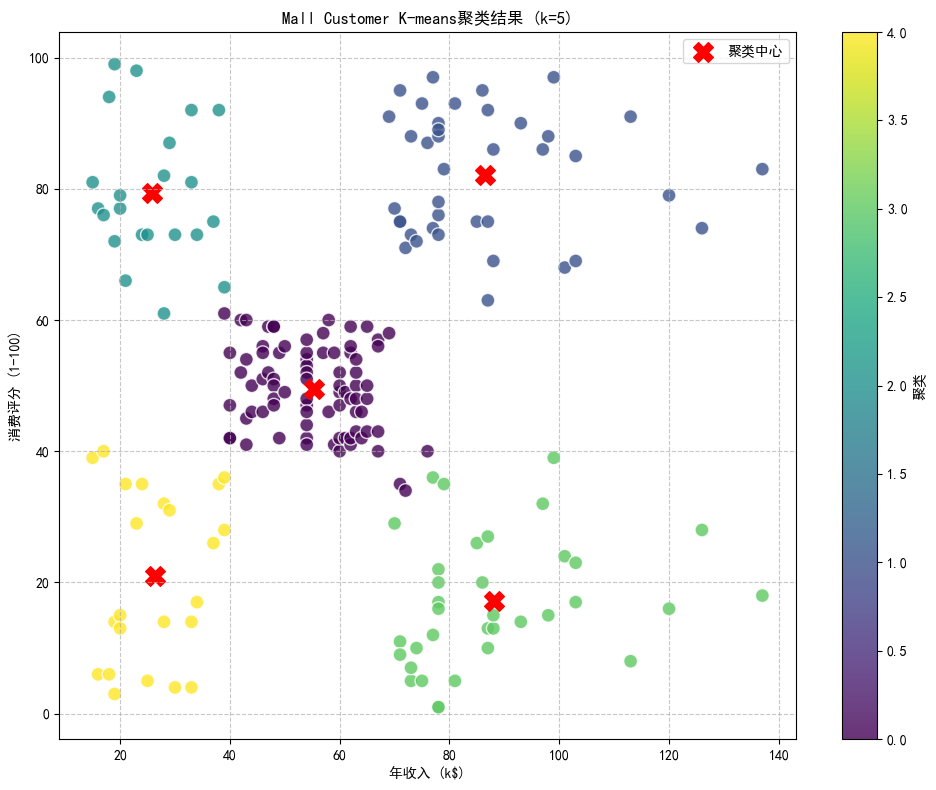

In [33]:
# 可视化聚类结果
def visualize_clusters(X, clusters, centers, feature_names, title="K-means聚类结果"):
    """可视化聚类结果"""
    plt.figure(figsize=(10, 8))
    
    # 绘制散点图
    scatter = plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', 
                          alpha=0.8, edgecolors='w', s=100)
    
    # 绘制聚类中心
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', 
                s=200, alpha=1, label='聚类中心')
    
    plt.colorbar(scatter, label='聚类')
    plt.title(title)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(os.path.join(output_folder, 'cluster_visualization.png'))
    plt.close()

# 可视化聚类结果
visualize_clusters(X_scaled, clusters, kmeans.cluster_centers_, 
                  ['标准化年收入', '标准化消费评分'], 
                  f"Mall Customer K-means聚类结果 (k={best_k})")

# 可视化原始数据的聚类结果
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X['Annual Income (k$)'], X['Spending Score (1-100)'], 
                     c=clusters, cmap='viridis', alpha=0.8, edgecolors='w', s=100)

# 将聚类中心转换回原始尺度
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers_original[:, 0], centers_original[:, 1], 
           c='red', marker='X', s=200, alpha=1, label='聚类中心')

plt.colorbar(scatter, label='聚类')
plt.title(f"Mall Customer K-means聚类结果 (k={best_k})")
plt.xlabel('年收入 (k$)')
plt.ylabel('消费评分 (1-100)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'cluster_visualization_original.png'))
plt.show()
# plt.close()

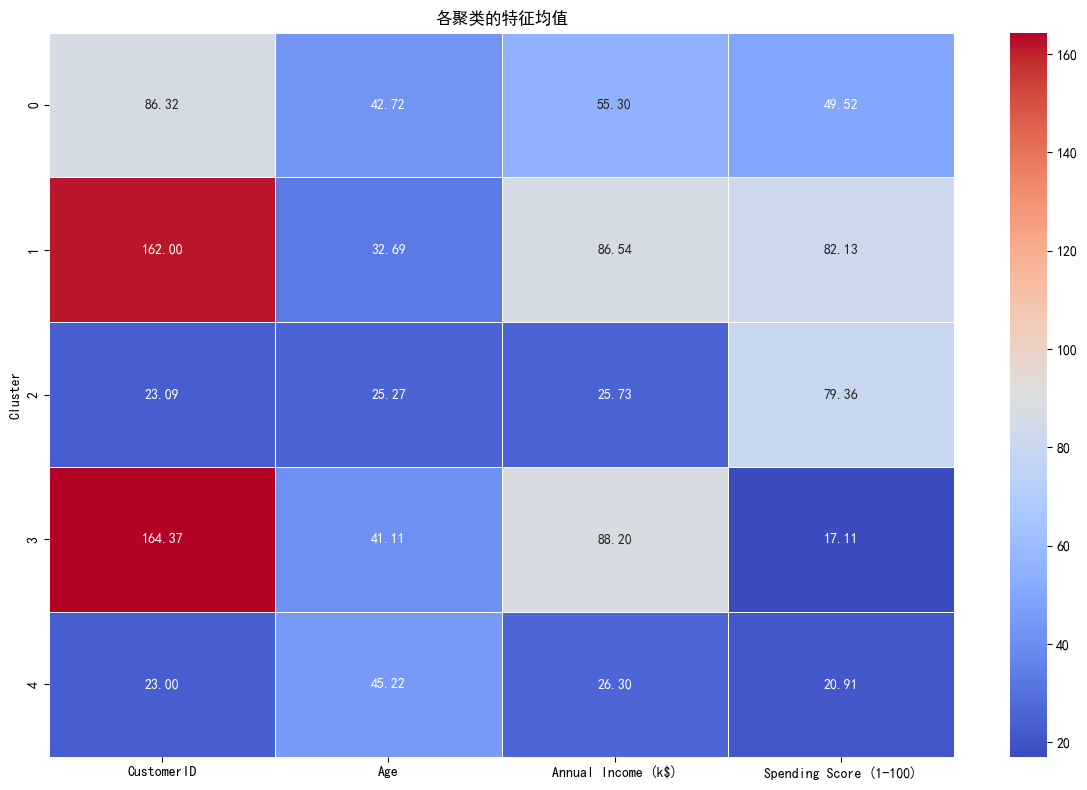

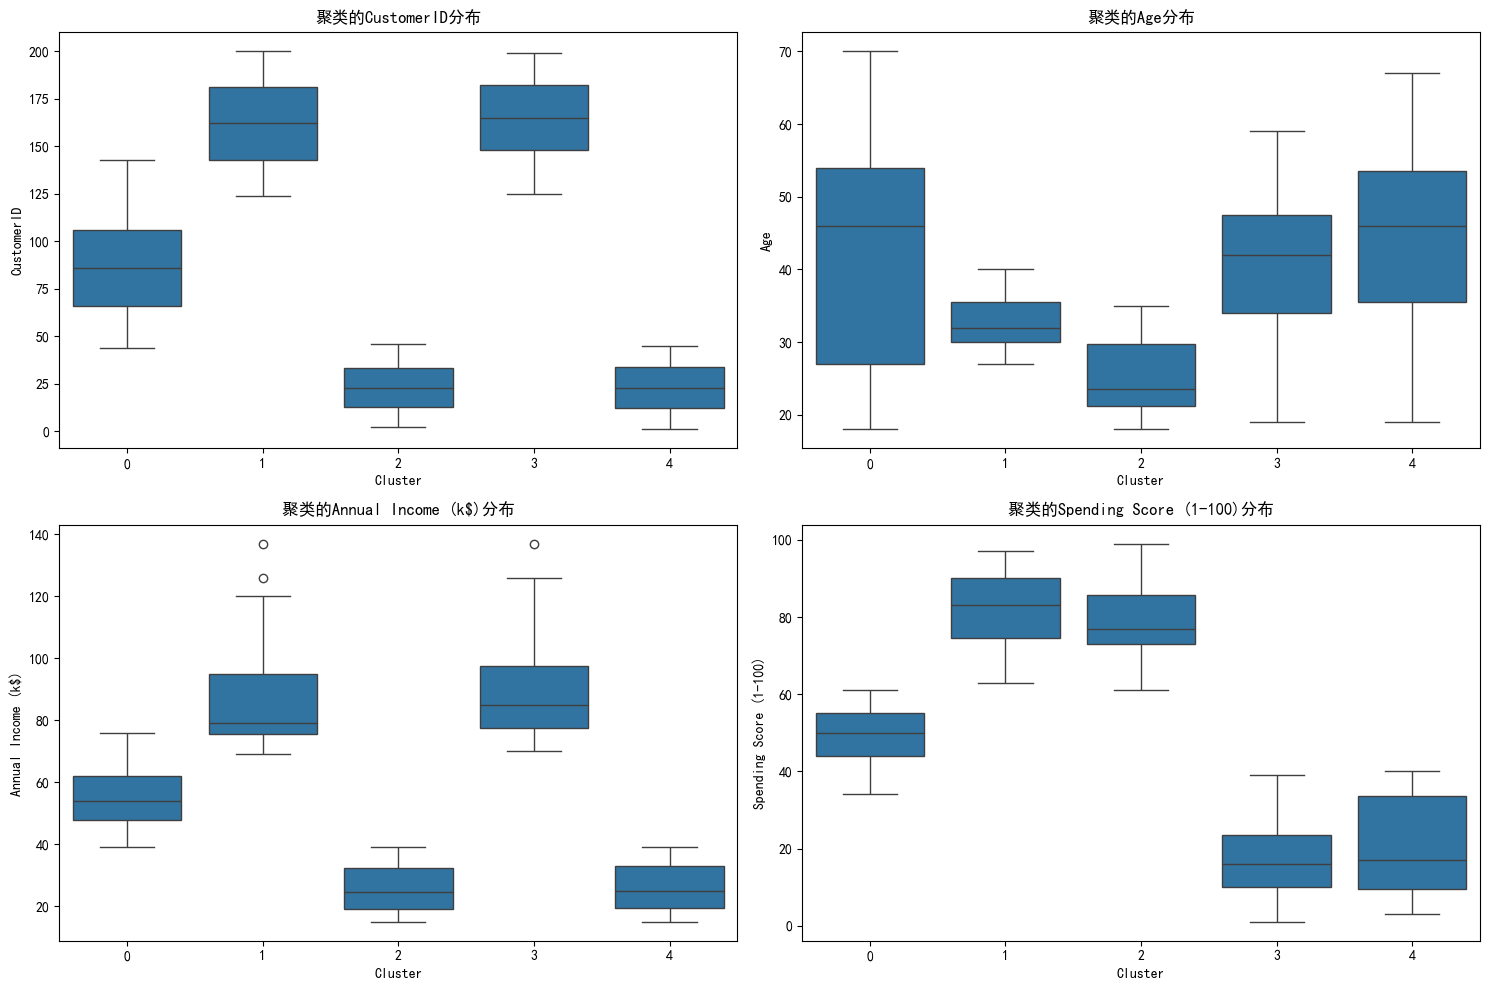

<Figure size 1000x600 with 0 Axes>

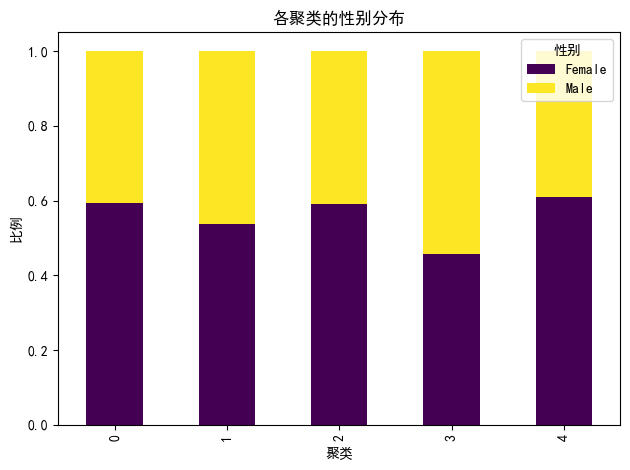


各聚类的特征均值:
         CustomerID        Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                                   
0         86.320988  42.716049           55.296296               49.518519
1        162.000000  32.692308           86.538462               82.128205
2         23.090909  25.272727           25.727273               79.363636
3        164.371429  41.114286           88.200000               17.114286
4         23.000000  45.217391           26.304348               20.913043


In [34]:
# 分析每个聚类的特征
def analyze_clusters(data, clusters):
    """分析每个聚类的特征分布"""
    # 添加聚类标签
    data_copy = data.copy()
    data_copy['Cluster'] = clusters
    
    # 计算每个聚类的特征均值 - 只使用数值型列
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    cluster_means = data_copy.groupby('Cluster')[numeric_cols].mean()
    
    # 绘制热图
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('各聚类的特征均值')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'cluster_features.png'))
    plt.show()
    # plt.close()
    
    # 绘制箱线图
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(numeric_cols):
        if i < 4:  # 限制最多显示4个特征
            plt.subplot(2, 2, i+1)
            sns.boxplot(x='Cluster', y=feature, data=data_copy)
            plt.title(f'聚类的{feature}分布')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'cluster_boxplots.png'))
    plt.show()
    # plt.close()
    
    # 分析性别分布（如果有）
    if 'Genre' in data.columns:
        gender_distribution = pd.crosstab(data_copy['Cluster'], data_copy['Genre'], normalize='index')
        
        plt.figure(figsize=(10, 6))
        gender_distribution.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title('各聚类的性别分布')
        plt.xlabel('聚类')
        plt.ylabel('比例')
        plt.legend(title='性别')
        plt.tight_layout()
        plt.savefig(os.path.join(output_folder, 'cluster_gender.png'))
        plt.show()
        # plt.close()
    
    return cluster_means

# 分析聚类特征
cluster_means = analyze_clusters(data, clusters)
print("\n各聚类的特征均值:")
print(cluster_means)

In [9]:
# 保存聚类结果
data_with_clusters.to_csv(os.path.join(output_folder, 'clustering_results.csv'), index=False)
print(f"\n聚类结果已保存至: {os.path.join(output_folder, 'clustering_results.csv')}")


聚类结果已保存至: ./kmeans_output\clustering_results.csv


In [10]:
# 总结聚类效果
print("\n聚类效果总结:")
print(f"- 最佳聚类数量: {best_k}")
print(f"- 轮廓系数: {silhouette_scores[best_k-2]:.4f}")
print(f"- 惯性 (簇内平方和): {inertia[best_k-2]:.4f}")
print(f"- 聚类结果已保存至输出文件夹: {output_folder}")


聚类效果总结:
- 最佳聚类数量: 5
- 轮廓系数: 0.5547
- 惯性 (簇内平方和): 65.5684
- 聚类结果已保存至输出文件夹: ./kmeans_output


In [ ]:
# 客户分群解释
print("\n客户分群解释:")
for i in range(best_k):
    cluster_data = data_with_clusters[data_with_clusters['Cluster'] == i]
    income_mean = cluster_data['Annual Income (k$)'].mean()
    spending_mean = cluster_data['Spending Score (1-100)'].mean()
    
    # 根据收入和消费评分特征解释客户群体
    income_level = "高" if income_mean > 60 else "中等" if income_mean > 40 else "低"
    spending_level = "高" if spending_mean > 60 else "中等" if spending_mean > 40 else "低"
    
    print(f"聚类 {i}: 包含 {len(cluster_data)} 名客户")
    print(f"   - 平均年收入: {income_mean:.2f}k$ ({income_level})")
    print(f"   - 平均消费评分: {spending_mean:.2f} ({spending_level})")
    
    # 根据收入和消费组合给出营销建议
    if income_level == "高" and spending_level == "高":
        print("   - 客户特征: 高收入高消费，忠诚顾客")
        print("   - 营销建议: 提供高端会员服务，保持客户忠诚度")
    elif income_level == "高" and spending_level != "高":
        print("   - 客户特征: 高收入低/中消费，潜力客户")
        print("   - 营销建议: 提供高质量产品促销，增加消费频率")
    elif income_level != "高" and spending_level == "高":
        print("   - 客户特征: 中/低收入高消费，价值客户")
        print("   - 营销建议: 提供会员积分和优惠券，维持消费水平")
    else:
        print("   - 客户特征: 中/低收入中/低消费，普通客户")
        print("   - 营销建议: 提供基础促销活动，提高客户参与度")


客户分群解释:
聚类 0: 包含 81 名客户
   - 平均年收入: 55.30k$ (中等)
   - 平均消费评分: 49.52 (中等)
   - 客户特征: 中/低收入中/低消费，普通客户
   - 营销建议: 提供基础促销活动，提高客户参与度

聚类 1: 包含 39 名客户
   - 平均年收入: 86.54k$ (高)
   - 平均消费评分: 82.13 (高)
   - 客户特征: 高收入高消费，忠诚顾客
   - 营销建议: 提供高端会员服务，保持客户忠诚度

聚类 2: 包含 22 名客户
   - 平均年收入: 25.73k$ (低)
   - 平均消费评分: 79.36 (高)
   - 客户特征: 中/低收入高消费，价值客户
   - 营销建议: 提供会员积分和优惠券，维持消费水平

聚类 3: 包含 35 名客户
   - 平均年收入: 88.20k$ (高)
   - 平均消费评分: 17.11 (低)
   - 客户特征: 高收入低/中消费，潜力客户
   - 营销建议: 提供高质量产品促销，增加消费频率

聚类 4: 包含 23 名客户
   - 平均年收入: 26.30k$ (低)
   - 平均消费评分: 20.91 (低)
   - 客户特征: 中/低收入中/低消费，普通客户
   - 营销建议: 提供基础促销活动，提高客户参与度

